In [1]:
import io
import numpy as np
import pandas as pd
import cv2
import fitz
import pyocr
from PIL import Image
from matplotlib import pyplot as plt

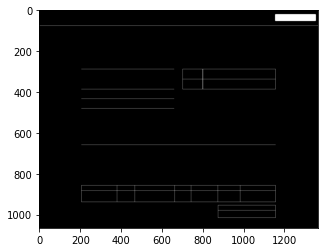

In [2]:
doc = fitz.open("resource/ANA領収書.pdf")
page = doc[0]

def get_drawing_pix(page):
    paths = page.get_drawings()  # extract existing drawings
    outpdf = fitz.open()
    outpage = outpdf.new_page(width=page.rect.width, height=page.rect.height)
    shape = outpage.new_shape()  # make a drawing canvas for the output page

    for path in paths:
        for item in path["items"]:  # these are the draw commands
            if item[0] == "l":  # line
                shape.draw_line(item[1], item[2])
            elif item[0] == "re":  # rectangle
                shape.draw_rect(item[1])
            elif item[0] == "qu":  # quad
                shape.draw_quad(item[1])
            elif item[0] == "c":  # curve
                shape.draw_bezier(item[1], item[2], item[3], item[4])
            else:
                raise ValueError("unhandled drawing", item)

        shape.finish(
            fill=path["fill"],  # fill color
            color=path["color"],  # line color
            dashes=path["dashes"],  # line dashing
            even_odd=path.get("even_odd", True),  # control color of overlaps
            closePath=path["closePath"],  # whether to connect last and first point
            lineJoin=path["lineJoin"],  # how line joins should look like
            lineCap=max(path["lineCap"]),  # how line ends should look like
            width=path["width"],  # line width
            stroke_opacity=path.get("stroke_opacity", 1),  # same value for both
            fill_opacity=path.get("fill_opacity", 1),  # opacity parameters
            )
    shape.commit()
    return outpage.get_pixmap()


def binarize_image(img, threshold=210):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, img_bin = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return img_bin


def get_pdf_image(page, resolution_rate=5.0):
    res_matrix = fitz.Matrix(resolution_rate, resolution_rate)
    pixmap = page.get_pixmap(matrix=res_matrix)
    img_rgb = np.asarray(Image.open(io.BytesIO(pixmap.tobytes())))
    return binarize_image(img_rgb)


pixmap = get_drawing_pix(page)
img1 = np.asarray(Image.open(io.BytesIO(pixmap.tobytes())))
img1_bin = binarize_image(img1)

plt.imshow(img1_bin, cmap="gray")
plt.show()

In [3]:
import re
from functools import lru_cache

class rdict(dict):
    '''Regex dictionary.
    
    This dictionary can take a regex pattern as a search key.
    '''
    def __getitem__(self, key):
        if isinstance(key, re.Pattern):
            pattern = key
            r = [v for k,v in self.items() if rdict._key_search(pattern, k)]
            if len(r) > 0:
                return r
            else:
                raise KeyError(key)
        else:
            return super().__getitem__(key)
    
    def rget(self, *keys):
        patterns = [rdict._key_compile(key) for key in keys]
        r = [v for k,v in self.items() 
             if all([rdict._key_search(p, k) for p in patterns])]
        if len(r) > 0:
            return r
        else:
            raise KeyError(key)
    
    def __contains__(self, key):
        if isinstance(key, re.Pattern):
            pattern = key
            m = [rdict._key_search(pattern, k) for k in self.keys()]
            return True if any(m) else False
        else:
            return super().__contains__(key)
    
    def is_rin(self, *keys):
        patterns = [rdict._key_compile(key) for key in keys]
        m = [all(rdict._key_search(p, k) for p in patterns) 
             for k in self.keys()]
        return True if any(m) else False
    
    @staticmethod
    @lru_cache(maxsize=128)
    def _key_compile(key):
        return re.compile(key)
    
    @staticmethod
    def _key_search(pattern, key):
        if isinstance(key, str):
            return re.search(pattern, key)
        elif isinstance(key, tuple):
            m = [pattern.search(k) for k in key]
            return m if any(m) else None

In [4]:
d = rdict()
d["foo"] = "nar"
d["baz"] = 100
d[("foo", "bar", "quot")] = 12345
d[340] = 1010

print(d)
p = re.compile("fo")
print(d[p])
print(d[340])
print(d.rget("ba*"))
print("fo" in d)
print(p in d)
print(d.is_rin("quot"))
print(d.rget("foo", "quo"))

{'foo': 'nar', 'baz': 100, ('foo', 'bar', 'quot'): 12345, 340: 1010}
['nar', 12345]
1010
[100, 12345]
False
True
True
[12345]


In [5]:
from copy import deepcopy

class Cell():
    def __init__(self, bbox, content, row_group=None, col_group=None):
        if not isinstance(content, str):
            raise TypeError("Cell content must be str")
        self.bbox = bbox
        self.content = content
        if row_group is None:
            self.row_group = set()
        if col_group is None:
            self.col_group = set()
    
    def __getitem__(self, key):
        return self.__getattribute__(key)
    
    def __setitem__(self, key, value):
        self.__setattr__(key, value)
    
    def __repr__(self):
        return f"{self.bbox}: {self.content}: {self.row_group}"
    
    def __eq__(self, other):
        if isinstance(other, Cell):
            return NotImplemented
        return self.bbox == other.bbox and self.content == other.content and \
               self.row_group == other.row_group and self.col_group == other.col_group
    
    def width(self):
        return self.bbox[2] - self.bbox[0]
    
    def height(self):
        return self.bbox[3] - self.bbox[1]


class Table():
    def __init__(self, cells=None, relation_infer_func=None, **kwargs):
        self.cells = None
        self.cell_matrix = None
        self.shape = None
        if cells is not None:
            self.load_cells(cells, relation_infer_func)
    
    def __getitem__(self, idx):
        return self.cell_matrix[idx]
    
    @staticmethod
    def _group_cells(cells, relation_infer_func=None, **kwargs):
        '''Label cells which row and column they are.
        
        Label cells which row and column they are.
        
        Parameters
        ----------
        cells: list[Cell]
            list of Cell which represents the bbox of each cell
        relation_infer_func: callable
            function which infers relation between a cell and the other and shall return Enum CellRelation
        
        Return
        ------
        cg_list: list[Cell]
            list of Cell whose row_group and col_group are set
        '''
        if relation_infer_func is None:
            relation_infer_func = lambda c1,c2: CellRelation.NONE
        
        row_count = col_count = 0
        _cells = deepcopy(cells)
        
        # group cells by row
        processed_cells = []
        _cells = sorted(_cells, key=lambda cell: cell.height())
        for cur_cell in _cells:
            for p_cell in processed_cells:
                relation = relation_infer_func(cur_cell, p_cell, **kwargs)
                if relation in (CellRelation.SAME_ROW, CellRelation.PARTIALLY_SAME_ROW):
                    cur_cell["row_group"].update(p_cell["row_group"])
            if len(cur_cell["row_group"]) == 0:
                cur_cell["row_group"].add(row_count)
                row_count += 1
            processed_cells.append(cur_cell)
        
        # group cells by column
        processed_cells.clear()
        _cells = sorted(_cells, key=lambda cell: cell.width())
        for cur_cell in _cells:
            for p_cell in processed_cells:
                relation = relation_infer_func(cur_cell, p_cell, **kwargs)
                if relation in (CellRelation.SAME_COL, CellRelation.PARTIALLY_SAME_COL):
                    cur_cell["col_group"].update(p_cell["col_group"])
            if len(cur_cell["col_group"]) == 0:
                cur_cell["col_group"].add(col_count)
                col_count += 1
            processed_cells.append(cur_cell)
        
        return _cells
    
    @staticmethod
    def _sort_cellgroup_index(cells):
        '''Sort row group and column group of the cell in ordinal order
        
        Sort row group and column group of the cell in ordinal order
        
        Parameter
        ---------
        cg_list: list[dict{'bbox', 'row_group', 'col_group'}]
            list of dict which has cell's bbox, row group and column group
        
        Return
        ------
        None
        '''
        row_group_representatives = []
        col_group_representatives = []
        for cell in cells:
            row_group = next(iter(cell["row_group"]))
            col_group = next(iter(cell["col_group"]))
            if len(cell["row_group"]) == 1 and \
               row_group not in map(lambda cell: cell["row_group"], row_group_representatives):
                row_group_representatives.append( {"bbox": cell["bbox"], "row_group": row_group} )
            if len(cell["col_group"]) == 1 and \
               col_group not in map(lambda cell: cell["col_group"], col_group_representatives):
                col_group_representatives.append( {"bbox": cell["bbox"], "col_group": col_group} )
        
        row_group_representatives.sort(key=lambda cell: cell["bbox"][1])
        col_group_representatives.sort(key=lambda cell: cell["bbox"][0])
        row_index_map = dict( [(cell["row_group"], idx) for idx, cell in enumerate(row_group_representatives)] )
        col_index_map = dict( [(cell["col_group"], idx) for idx, cell in enumerate(col_group_representatives)] )
        
        for cell in cells:
            cell["row_group"] = { row_index_map[orig_idx] for orig_idx in cell["row_group"] }
            cell["col_group"] = { col_index_map[orig_idx] for orig_idx in cell["col_group"] }
        
    
    def load_cells(self, cells, relation_infer_func=None, **kwargs):
        '''Load cells to the table.
        
        Load cells to the table.
        
        Parameters
        ----------
        cells: list[Cell]
            list of dict which represents a bbox (x1,y1,x2,y2) and a content of the cell
        
        Returns
        -------
        shape of the table constructed from the cells
        '''
        self.cells = Table._group_cells(cells, relation_infer_func, **kwargs)
        Table._sort_cellgroup_index(self.cells)
        
        num_row = max([max(cg["row_group"]) for cg in self.cells]) + 1
        num_col = max([max(cg["col_group"]) for cg in self.cells]) + 1
        nan_cell = Cell(bbox=(np.nan, np.nan, np.nan, np.nan), content="")
        self.cell_matrix = np.full((num_row, num_col), nan_cell, dtype=object)
        
        for cell in self.cells:
            for row in cell["row_group"]:
                for col in cell["col_group"]:
                    self.cell_matrix[row,col] = cell
        
        # complement cells
        x1s, y1s, x2s, y2s = [], [], [], []
        for row in range(num_row):
            y1s.append( np.nanmean([cell.bbox[1] for cell in self.cell_matrix[row,:]
                                    if len(cell["row_group"]) == 1]) )
            y2s.append( np.nanmean([cell.bbox[3] for cell in self.cell_matrix[row,:]
                                    if len(cell["row_group"]) == 1]) )
        for col in range(num_col):
            x1s.append( np.nanmean([cell.bbox[0] for cell in self.cell_matrix[:,col]
                                    if len(cell["col_group"]) == 1]) )
            x2s.append( np.nanmean([cell.bbox[2] for cell in self.cell_matrix[:,col]
                                    if len(cell["col_group"]) == 1]) )
        for row in range(num_row):
            for col in range(num_col):
                if self.cell_matrix[row,col] == nan_cell:
                    self.cell_matrix[row,col] = Cell((x1s[col],y1s[row],x2s[col],y2s[row]), "")
        self.shape = (num_row, num_col)
        return (num_row, num_col)
        
    
    def is_row_merged_cell(self, i, j):
        return True if len(self[i,j]["row_group"]) >= 2 else False
    
    def is_col_merged_cell(self, i, j):
        return True if len(self[i,j]["col_group"]) >= 2 else False
    
    def get_bbox(self):
        x1 = np.nanmean([cell.bbox[0] for cell in self.cell_matrix[:,0]])
        y1 = np.nanmean([cell.bbox[1] for cell in self.cell_matrix[0,:]])
        x2 = np.nanmean([cell.bbox[2] for cell in self.cell_matrix[:,-1]])
        y2 = np.nanmean([cell.bbox[3] for cell in self.cell_matrix[-1,:]])
        return (x1,y1,x2,y2)
    
    def get_width(self):
        bbox = self.get_bbox()
        return bbox[2] - bbox[0]
    
    def get_height(self):
        bbox = self.get_bbox()
        return bbox[3] - bbox[1]
    
    def get_width_of_col(self, col):
        x1 = np.nanmean([cell.bbox[0] for cell in self.cell_matrix[:,col]])
        x2 = np.nanmean([cell.bbox[2] for cell in self.cell_matrix[:,col]])
        return x2 - x1
    
    def get_height_of_row(self, row):
        y1 = np.nanmean([cell.bbox[1] for cell in self.cell_matrix[row,:]])
        y2 = np.nanmean([cell.bbox[3] for cell in self.cell_matrix[row,:]])
        return y2 - y1

In [6]:
from enum import Enum

class CellRelation(Enum):
    NONE = 0
    SAME_CELL = 1
    SAME_ROW = 2
    SAME_COL = 3
    PARTIALLY_SAME_ROW = 4
    PARTIALLY_SAME_COL = 5
    INSIDE_CELL = 6
    #R_PARTIALLY_SAME_ROW = 4    # overlaps partially and horizontally with the right cell bigger
    #L_PARTIALLY_SAME_ROW = 5    # overlaps partially and horizontally with the left cell bigger
    #T_PARTIALLY_SAME_COL = 6    # overlaps partially and vertically with the top cell bigger
    #B_PARTIALLY_SAME_COL = 7    # overlaps partially and vertically with the bottom cell bigger
    #INSIDE_CELL = 8
    

def infer_cell_relation(cell1, cell2, threshold=0.9):
    sx1, sy1, ex1, ey1 = cell1["bbox"]
    sx2, sy2, ex2, ey2 = cell2["bbox"]
    w1, h1 = ex1 - sx1, ey1 - sy1
    w2, h2 = ex2 - sx2, ey2 - sy2
    overlap_x = min(w1, w2, ex1 - sx2, ex2 - sx1)
    overlap_y = min(h1, h2, ey1 - sy2, ey2 - sy1)
    
    row_relation = "none"
    col_relation = "none"
    if overlap_x > min(w1,w2)*threshold:
        # the two cell overlaps vertically
        if overlap_x > w1*threshold and overlap_x > w2*threshold:
            col_relation =  "same"
        else:
            col_relation = "partial"
    if overlap_y > min(h1,h2)*threshold:
        # the two cell overlaps horizontally
        if overlap_y > h1*threshold and overlap_y > h2*threshold:
            row_relation = "same"
        else:
            row_relation = "partial"
    
    if row_relation == "same" and col_relation == "same":
        return CellRelation.SAME_CELL
    elif row_relation != "none" and col_relation != "none":
        return CellRelation.INSIDE_CELL
    elif row_relation == "same":
        return CellRelation.SAME_ROW
    elif row_relation == "partial":
        return CellRelation.PARTIALLY_SAME_ROW
    elif col_relation == "same":
        return CellRelation.SAME_COL
    elif col_relation == "partial":
        return CellRelation.PARTIALLY_SAME_COL
    else:
        return CellRelation.NONE


def get_bbox(contour):
    min_x = contour[:,0,0].min()
    max_x = contour[:,0,0].max()
    min_y = contour[:,0,1].min()
    max_y = contour[:,0,1].max()
    return (min_x, min_y, max_x, max_y)


def does_bbox_include(small, large):
    if large[0] <= small[0] <= small[2] <= large[2] and \
       large[1] <= small[1] <= small[3] <= large[3]:
        return True
    else:
        return False

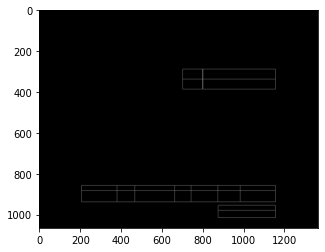

In [7]:
from collections import defaultdict

contours1, hierarchy1 = cv2.findContours(img1_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
tables_raw = defaultdict(list)
img1_cp = np.zeros_like(img1_bin)
for i, cont in enumerate(contours1):
    if hierarchy1[0][i][2] == -1 and hierarchy1[0][i][3] != -1:    # the most inside cell
        bbox = get_bbox(cont)
        tables_raw[hierarchy1[0][i][3]].append(Cell(bbox, ""))
        cv2.drawContours(img1_cp, contours1, i, 255, 1)
plt.imshow(img1_cp, cmap="gray")
plt.show()

In [8]:
tables = []
for cells in tables_raw.values():
    for cell in cells:
        cell.content = page.get_text(clip=cell.bbox)
    table = Table(cells, infer_cell_relation)
    tables.append(table)

print(table[1,0])

(702, 337, 800, 386): 照会番号
: {1}


<IPython.core.display.Javascript object>


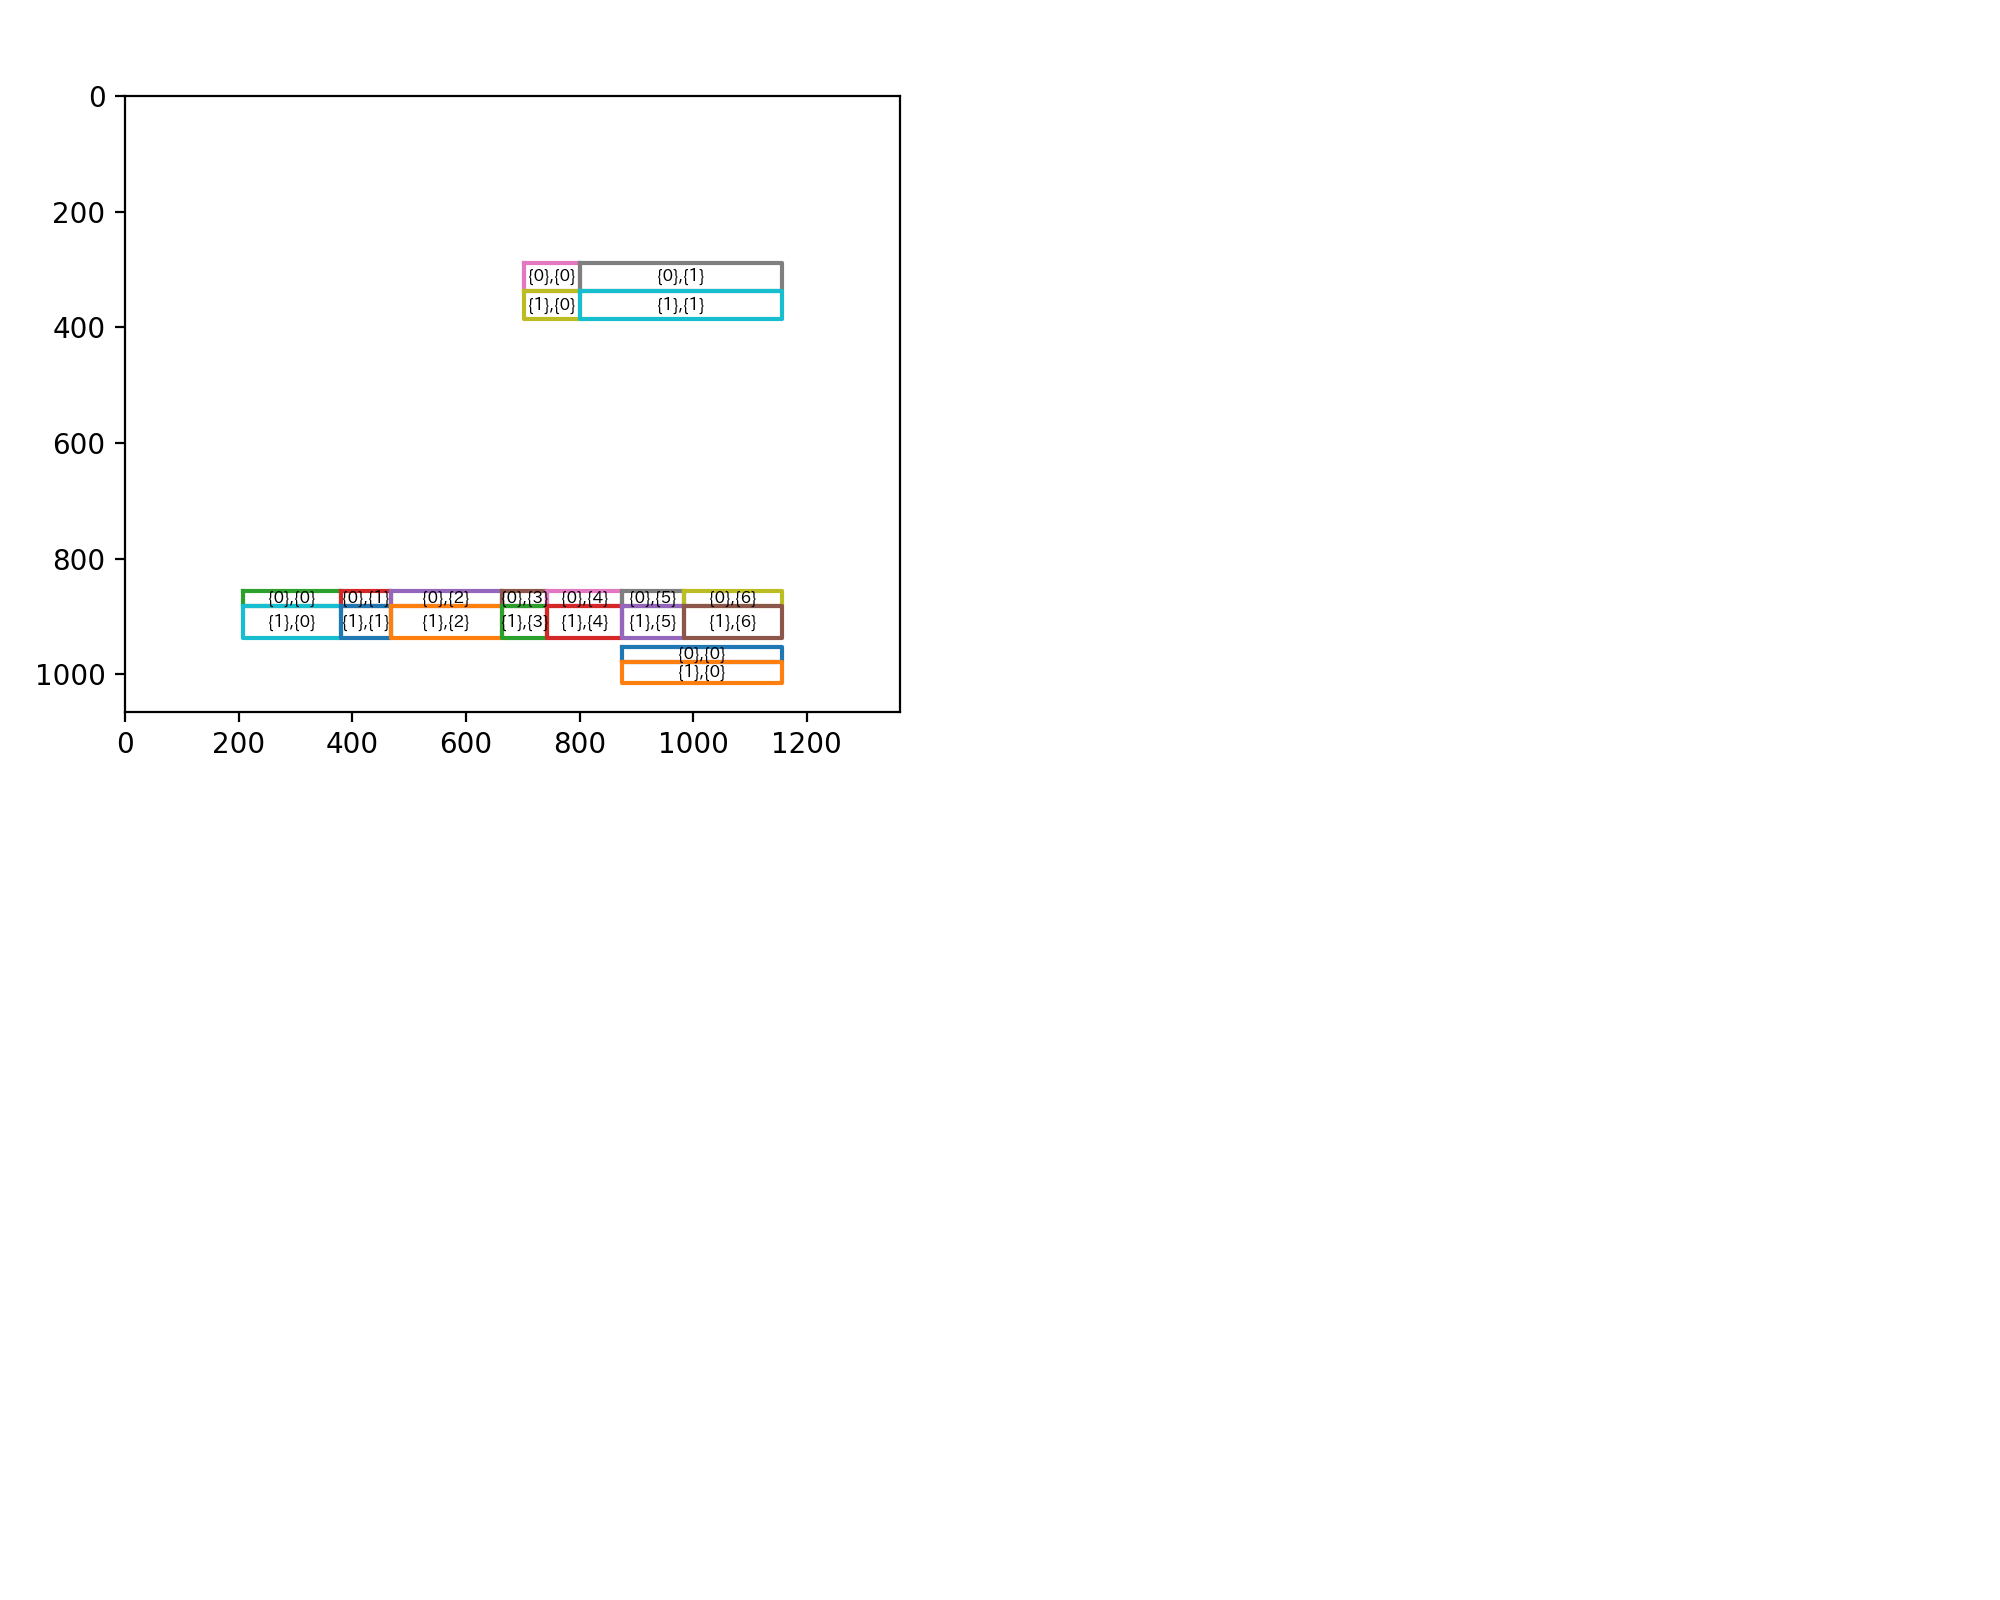

In [9]:
from matplotlib.font_manager import FontProperties

fp = FontProperties(fname="/Users/ekohei/Downloads/ipaexg00401/ipaexg.ttf", size=16)

def plot_square(ax=plt, bbox=(0,0,1,1), label=None):
    p1 = [bbox[0],bbox[1]]
    p2 = [bbox[2],bbox[1]]
    p3 = [bbox[2],bbox[3]]
    p4 = [bbox[0],bbox[3]]
    ps = np.array([p1,p2,p3,p4,p1])
    ax.plot(ps[:,0], ps[:,1])
    if label is not None:
        cx = (bbox[0] + bbox[2])/2
        cy = (bbox[1] + bbox[3])/2
        ax.text(cx, cy, label, ha="center", va="center", fontsize=6, fontproperties=fp)
    return

%matplotlib notebook
fig, ax = plt.subplots(figsize=(5,4))
for table in tables:
    nrow, ncol = table.shape
    for i in range(nrow):
        for j in range(ncol):
            cell = table[i,j]
            plot_square(ax, cell["bbox"], f"{cell['row_group']},{cell['col_group']}")
ax.set_xlim(0,1364)
ax.set_ylim(1065,0)
plt.show()

<IPython.core.display.Javascript object>


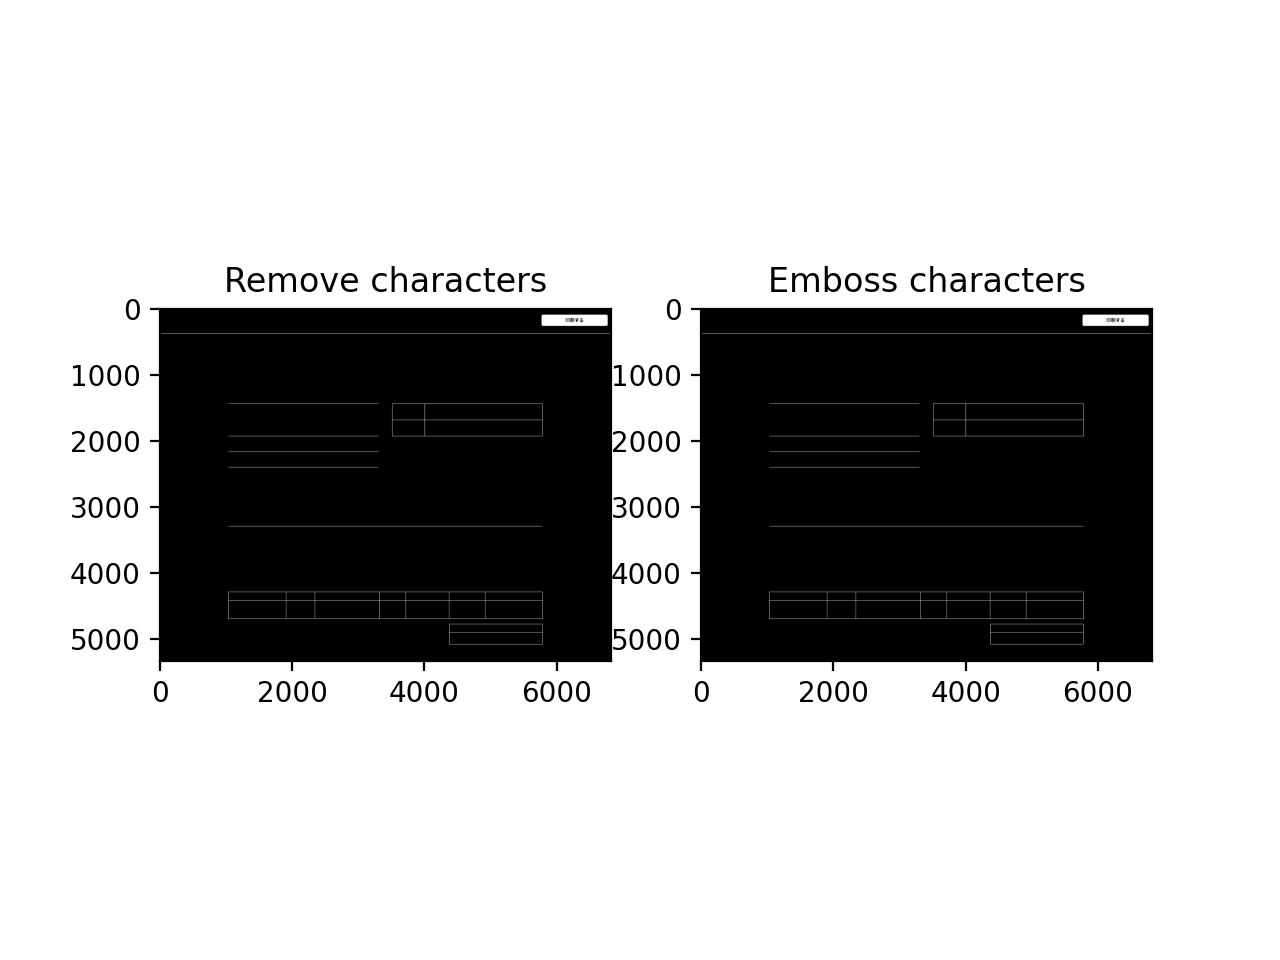

In [10]:
def logarithm_threshold(bbox_whs):
    non_zero_whs = bbox_whs[np.all(bbox_whs > 0, axis=1)]
    bbox_whs_log = np.log2(non_zero_whs)
    widths = bbox_whs_log[:,0].copy()
    heights = bbox_whs_log[:,1].copy()
    widths.sort()
    heights.sort()
    w_diffs = np.diff(widths)
    h_diffs = np.diff(heights)
    w_threshold = np.exp2( widths[w_diffs.argmax()] + w_diffs.max()/2 )
    h_threshold = np.exp2( heights[h_diffs.argmax()] + h_diffs.max()/2 )
    
    return (w_threshold, h_threshold)

def remove_characters(img_bin, character_check_threshold=0.1):
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours_ext = tuple( (cont for i,cont in enumerate(contours) if hierarchy[0][i][3] == -1) )
    bbox_whs = np.array([(bbox[2]-bbox[0], bbox[3]-bbox[1]) for bbox in map(get_bbox, contours_ext)])
    
    img_cp = img_bin.copy()
    character_check_threshold = character_check_threshold*min(img_bin.shape)
    # If there are no 'small' figures, do nothing
    if np.any(img_bin > character_check_threshold, axis=1).all():
        return img_cp
    
    w_threshold = logarithm_threshold(bbox_whs)[0]
    for i, cont in enumerate(contours_ext):
        # remove characters (which should be small figures) by filling black
        if bbox_whs[i,0] < w_threshold:
            cv2.drawContours(img_cp, contours_ext, i, 0, -1)
    return img_cp

def emboss_characters(img_bin):
    img_cp = img_bin.copy()
    img_nochars = remove_characters(img_bin)
    img_nochars = cv2.dilate(img_nochars, kernel=np.ones((6,6), np.uint8))
    img_chars = np.where(img_nochars==255, 0, img_cp)
    return img_chars

def extract_tables(img_bin, scale=1):
    img_tables = remove_characters(img_bin)
    contours, hierarchy = cv2.findContours(img_tables, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    tables_raw = defaultdict(list)
    for i, cont in enumerate(contours):
        if hierarchy[0][i][2] == -1 and hierarchy[0][i][3] != -1:    # the most inside cell
            bbox = get_bbox(cont)
            bbox = tuple(b//scale for b in bbox)
            tables_raw[hierarchy[0][i][3]].append(Cell(bbox, ""))
    tables = []
    for cells in tables_raw.values():
        table = Table(cells, infer_cell_relation)
        tables.append(table)
    return tables


zoom = fitz.Matrix(5, 5)
img2_pil = Image.open(io.BytesIO(page.get_pixmap(matrix=zoom).tobytes()))
img2 = np.asarray(img2_pil)
img2_bin = binarize_image(img2)
img_nochars = remove_characters(img2_bin)
img_chars = emboss_characters(img2_bin)

plt.subplot(121)
plt.title("Remove characters")
plt.imshow(img_nochars, cmap="gray")
plt.subplot(122)
plt.title("Emboss characters")
#plt.imshow(img_chars, cmap="gray")
plt.imshow(img_nochars, cmap="gray")
plt.show()

In [11]:
contours, hierarchy = cv2.findContours(img_nochars, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_ext = tuple( (cont for i,cont in enumerate(contours) if hierarchy[0][i][3] == -1) )
bbox_whs = np.array([(bbox[2]-bbox[0], bbox[3]-bbox[1]) for bbox in map(get_bbox, contours_ext)])
cch = 0.1*min(img_nochars.shape)
np.any(bbox_whs > cch, axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [189]:
xy = "#001.y2"
re.match(r"^#\d+\.(x|y)(1|2)$", xy)
1 == "1"

False

In [13]:
import json

In [ ]:
class WordBoxDetector:
    def __init__(self):
        pass
    
    def listup(self, page):
        return []

class PDFWordBoxDetector(WordBoxDetector):
    def __init__(self):
        pass
    
    def listup(self, page):
        words = page.get_text(option="words", sort=True)
        words = [word[:5] for word in words]
        return words
    
    def detect(self, page, bbox):
        text = page.get_text(clip=bbox)
        return text

class OCRWordBoxDetector(WordBoxDetector):
    def __init__(self, resolution_rate=5):
        self.resolution_rate = resolution_rate
        self.tool = pyocr.get_available_tools()[0]
        self.builder = pyocr.builders.WordBoxBuilder(tesseract_layout=6)
    
    def listup(self, page):
        img_page_bin = get_pdf_image(page, self.resolution_rate)
        img_chars = emboss_characters(img_page_bin)
        words = self.tool.ima

In [11]:
def parse_position(position, frame, pattern_idmap, max_ref_depth=10):
    if max_ref_depth < 0:
        raise Exception("Limit of depth exceeded while parsing position!")
    
    parsed = []
    for i, p in enumerate(position):
        if isinstance(p, int):
            parsed.append(p)
        elif isinstance(p, str) and re.match(r"^#\d+\.(x|y)(1|2)$", p):
            ref, xyidx = p.split('.')
            try:
                target = pattern_idmap[ int(ref[1:]) ]["position"]
                xyidx = ["x1","y1","x2","y2"].index(xyidx)
            except:
                raise SyntaxError(f"pattern {ref} not found!")
            parsed.append( parse_position(target, frame, pattern_idmap, max_ref_depth-1)[xyidx] )
        elif isinstance(p, str) and p == "*":
            parsed.append(int(frame[i]))
        else:
            raise SyntaxError("Invalid position format!")
    return tuple(parsed)


def match_score(pattern_file, page, **kwargs):
    resolution_rate = kwargs["resolution_rate"] if "resolution_rate" in kwargs else 5.0
    img_page = kwargs["img_page"] if "img_page" in kwargs \
               else get_pdf_image(page, resolution_rate)
    tables_page = kwargs["tables_page"] if "tables_page" in kwargs \
                  else extract_tables(img_page, scale=int(resolution_rate))
    table_shapes = [table.shape for table in tables_page]
    match = 0
    
    with open(pattern_file, 'r') as f:
        patterns = json.load(f)["patterns"]
    pattern_idmap = dict([(p["id"],p) for p in patterns])
    for pattern in patterns:
        position = parse_position(pattern["position"], tuple(page.rect), pattern_idmap)
        print(f"pattern position: {position}")
        if pattern["type"] == "textbox" and pattern["action"] == "check_format":
            extracted_text = page.get_text(clip=position).replace("\n", "")
            if extracted_text == pattern["content"]:
                match += 1
        elif pattern["type"] == "table":
            matched_table = None
            for table in tables_page:
                if does_bbox_include(table.get_bbox(), position) and table.shape == tuple(pattern["shape"]):
                    match += 1
                    matched_table = table
                    break
            if matched_table:
                for pcell in pattern["cells"]:
                    if pcell["type"] == "table-header":
                        rows, cols = pcell["row"], pcell["col"]
                        matched_cell = matched_table[rows[0],cols[0]]
                        if pcell["content"] == matched_cell.content:
                            print(f"matched cell content: {matched_cell.content}")
                            match += 1
                        if matched_cell.row_group == set(rows) and matched_cell.col_group == set(cols):
                            print(f"matched cell row-col group: {matched_cell.row_group}")
                            match += 1
    return match

In [14]:
match_score("patterns/pattern_test.json", page)

pattern position: (200, 120, 320, 180)
pattern position: (210, 300, 250, 330)
pattern position: (350, 300, 500, 340)
pattern position: (630, 210, 680, 260)
pattern position: (200, 210, 600, 260)
pattern position: (700, 280, 1160, 400)
matched cell row-col group: {0}
matched cell row-col group: {1}


6

<IPython.core.display.Javascript object>


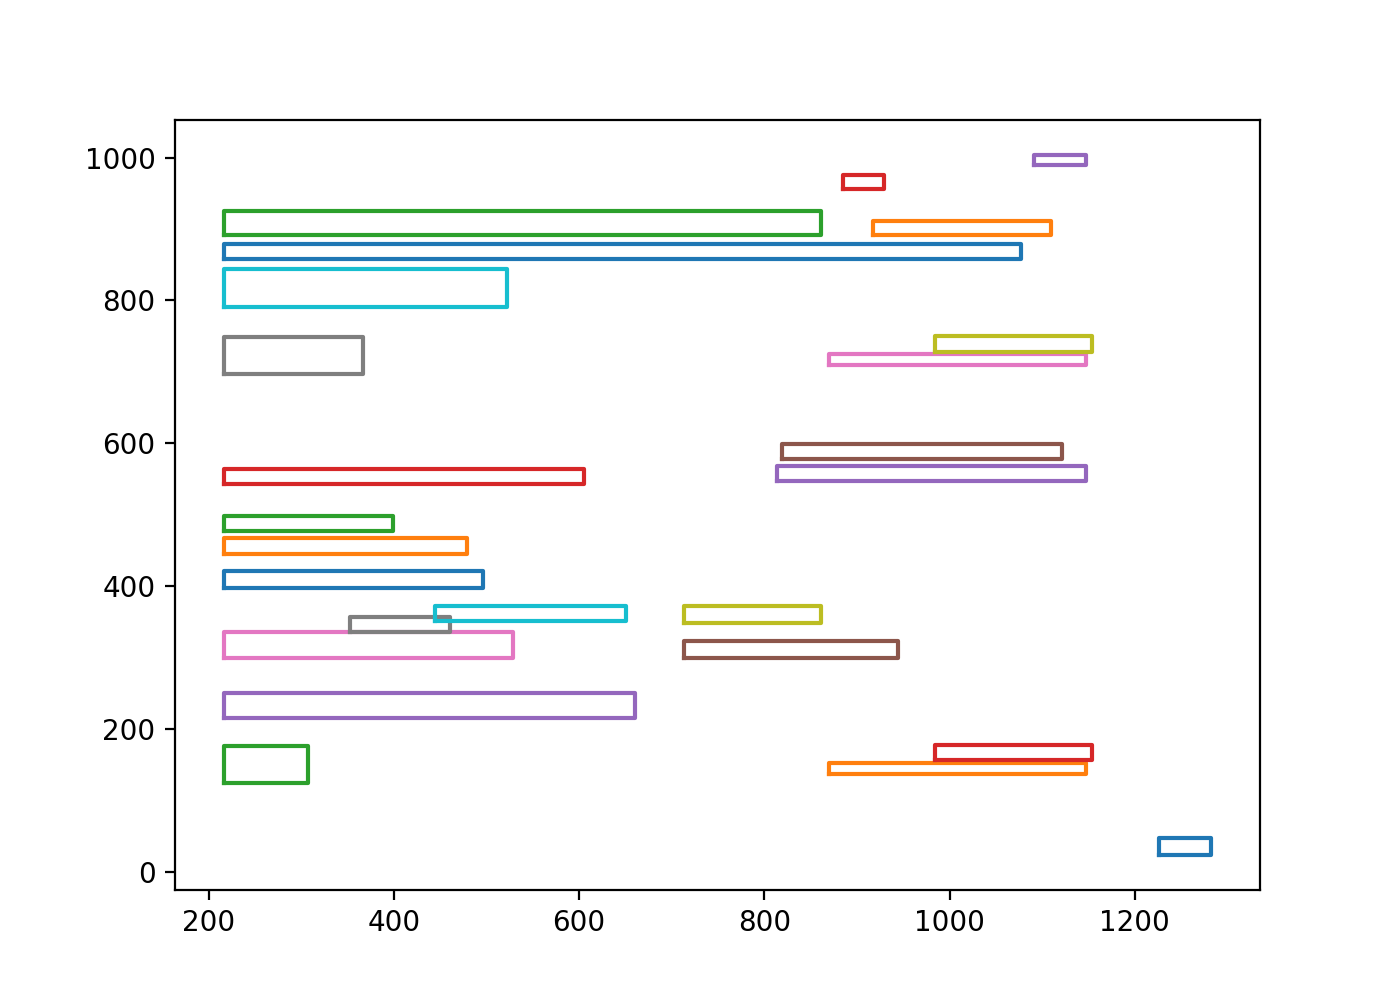

In [15]:
tbs = page.get_text_blocks(sort=True)
i = get_pdf_image(page, resolution_rate=1)
plt.figure(figsize=(7,5))
#plt.imshow(i, cmap="gray")
for tb in tbs:
    bbox = tb[:4]
    content = tb[4]
    #print(tb)
    plot_square(plt, bbox)
plt.show()

<IPython.core.display.Javascript object>


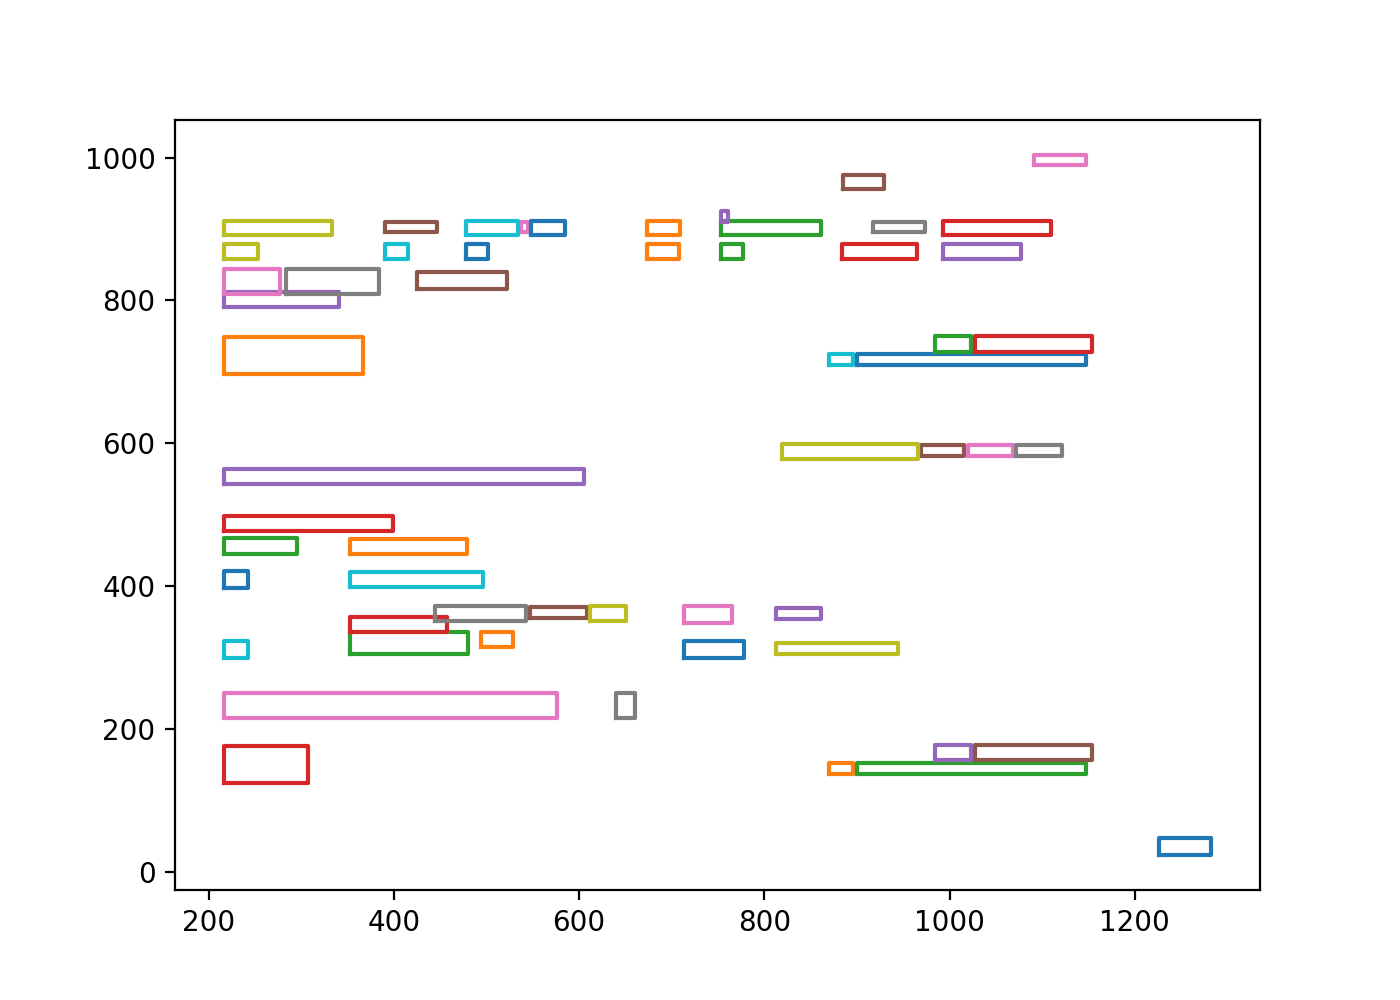

(640.0, 216.3800048828125, 660.0, 250.94000244140625, '様', 9, 1, 0)


In [18]:
ws = page.get_text(option="words", sort=True)
plt.figure(figsize=(7,5))
#plt.imshow(i, cmap="gray")
for w in ws:
    bbox = w[:4]
    content = w[4]
    #print(w)
    plot_square(plt, bbox)
plt.show()

print([w for w in ws if w[4] == '様'][0])

In [23]:
page.get_text(option="blocks", clip=(630,210,680,251))

[(640.0, 216.3800048828125, 660.0, 250.94000244140625, '様\n', 0, 0)]

<IPython.core.display.Javascript object>


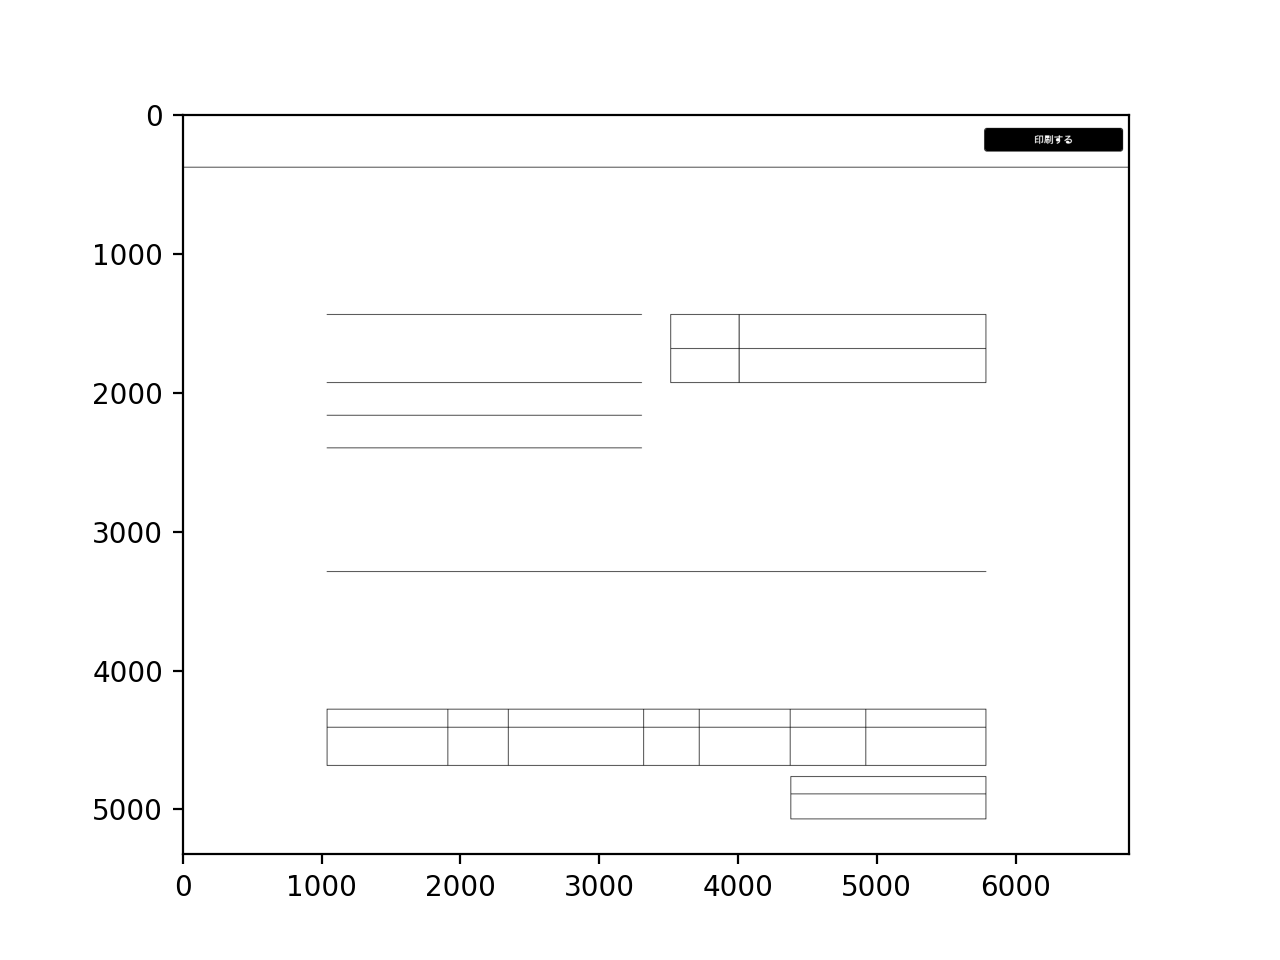

In [37]:
def pos_to_bbox(pos):
    x1, y1 = pos[0]
    x2, y2 = pos[1]
    return (x1, y1, x2, y2)

tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.WordBoxBuilder(tesseract_layout=6)
result = tool.image_to_string(img2_pil, lang="jpn", builder=builder)
plt.imshow(img_nochars, cmap="binary")
for r in result:
    bbox = pos_to_bbox(r.position)
    content = r.content
    #plot_square(ax=plt, bbox=bbox, label=content)

plt.show()

In [26]:
%time parse_position([1,"#1.x1",3,"#1.y2"], [0,0,100,200], {1:{"type":"textbox","position":[20,30,50,70]}})

CPU times: user 27 µs, sys: 2 µs, total: 29 µs
Wall time: 34.1 µs


(1, 20, 3, 70)

In [87]:
def read_json_repeatedly(file, repeat=100):
    for _ in range(repeat):
        with open(file, 'r') as f:
            j = json.load(f)

%time read_json_repeatedly("patterns/pattern_test.json", repeat=1000)

CPU times: user 49.5 ms, sys: 19.4 ms, total: 68.9 ms
Wall time: 68.6 ms


<IPython.core.display.Javascript object>


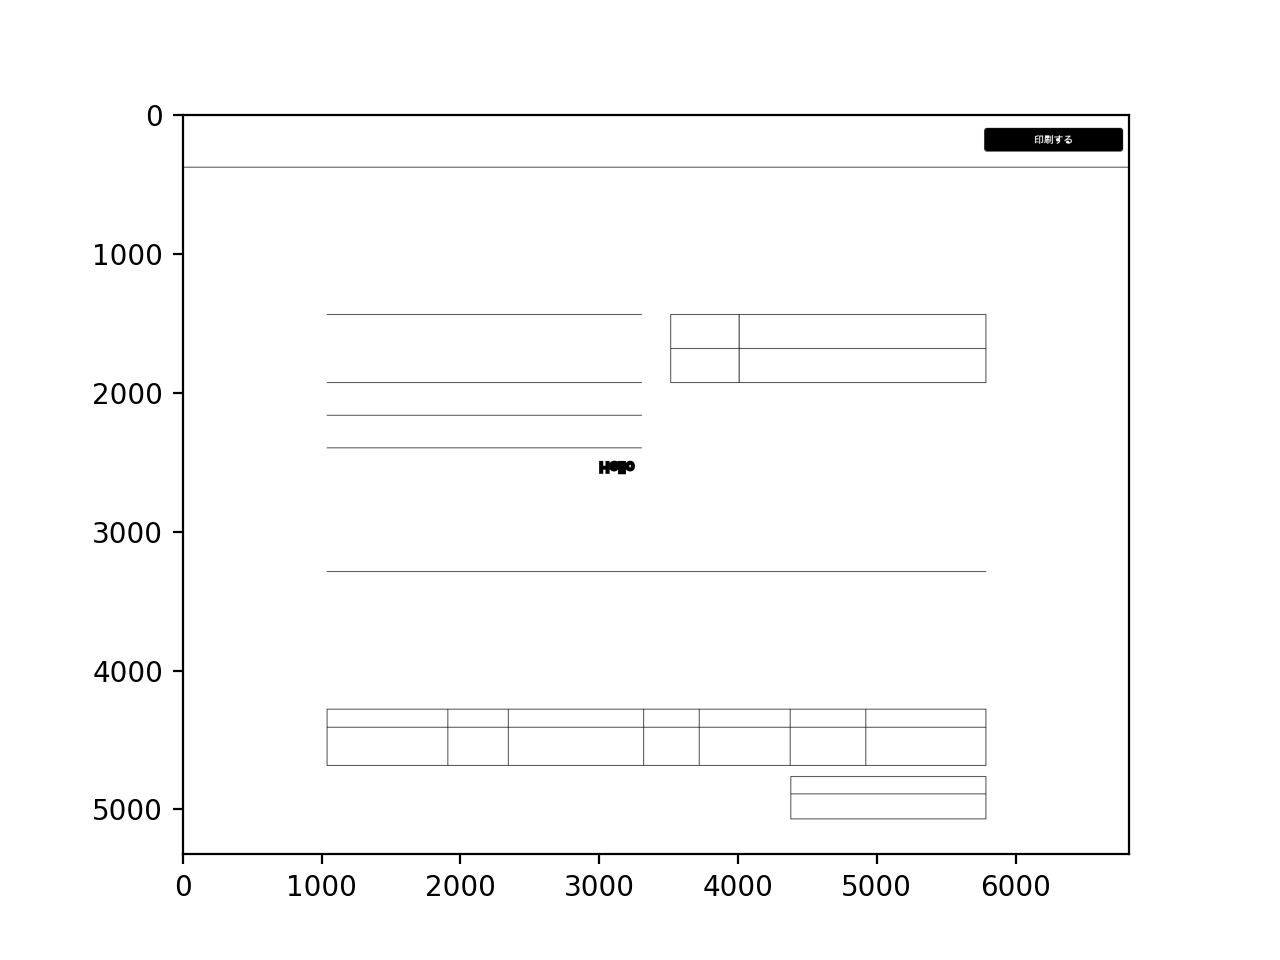

In [36]:
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch

plt.imshow(img_nochars, cmap="binary")
tp = TextPath((3000,2500), "Hello", size=100)
plt.gca().add_patch(PathPatch(tp, color="black"))
plt.show()

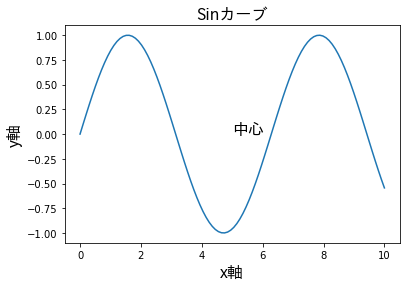

In [88]:
from matplotlib.font_manager import FontProperties

fp = FontProperties(fname="/Users/ekohei/Downloads/ipaexg00401/ipaexg.ttf", size=16)

# path = "/Users/ekohei/Downloads/ipaexg00401/ipaexg.ttf"
# prop = FontProperties(fname=path)
# matplotlib.rcParams['font.family'] = prop.get_name()
# print(prop.get_name())

%matplotlib inline
xs = np.linspace(0,10, 100)
ys = np.sin(xs)
plt.plot(xs,ys)
plt.xlabel("x軸", fontproperties=fp)
plt.ylabel("y軸", fontproperties=fp)
plt.title("Sinカーブ", fontproperties=fp)
plt.text(5,0,"中心", fontproperties=fp)
plt.show()